In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import utilssphering
import utils
import os
import random
import numpy as np
import itertools
import pycytominer
import matplotlib.pyplot as plt
import ast

random.seed(9000)

In [3]:
import matplotlib 
# Get versions of stuff, if you want
print(
    pd.__version__,
    np.version.version,
    matplotlib.__version__
)

1.4.2 1.22.4 3.5.2


In [25]:
# merge experiment and fov metadata DFs together.

fov = pd.read_csv("output/FoV-experiment-metadata.tsv", sep="\t").drop(columns=("Batch")).rename(columns={"FoV_Batch": "Batch"})

orig = pd.read_csv('output/experiment-metadata-updated.csv')
comb = pd.concat([fov, orig], ignore_index=True)
comb["sites"] = comb["Sites-SubSampled"]
comb["sites"].fillna(comb["Images_per_well"], inplace=True)
comb.to_csv("output/all-profile-metadata.csv", index_label='index', index=False)
comb

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,z_plane,BF_Zplanes,Anomaly,spinning-disc,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites
0,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,1.0,1,10,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
1,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,1.0,1,10,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
2,MolDev,1siteSubSample_Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,1.0,1,10,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
3,MolDev,1siteSubSample_Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,1.0,1,20,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
4,MolDev,1siteSubSample_Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,1.0,1,20,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,NaN,1,20,5,12,none,none,NaN,1.0,immersion,no,2.0,9.0
180,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117033,JUMP-MOA_compound_platemap,BRO0117033_20x,Confocal,9,NaN,1,20,6,12,11,none,NaN,1.0,immersion,yes,2.0,9.0
181,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,NaN,1,20,6,12,15,none,NaN,1.0,immersion,yes,4.0,9.0
182,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,NaN,1,20,6,12,13,none,NaN,1.0,immersion,yes,1.0,9.0


In [8]:
# Read new experiment df

experiment_df = pd.read_csv("output/all-profile-metadata.csv")

experiment_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,z_plane,BF_Zplanes,Anomaly,spinning-disc,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites
0,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,1.0,1,10,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
1,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,1.0,1,10,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
2,MolDev,1siteSubSample_Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,1.0,1,10,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
3,MolDev,1siteSubSample_Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,1.0,1,20,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
4,MolDev,1siteSubSample_Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,1.0,1,20,6,1,NaN,none,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,NaN,1,20,5,12,none,none,NaN,1.0,immersion,no,2.0,9.0
180,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117033,JUMP-MOA_compound_platemap,BRO0117033_20x,Confocal,9,NaN,1,20,6,12,11,none,NaN,1.0,immersion,yes,2.0,9.0
181,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,NaN,1,20,6,12,15,none,NaN,1.0,immersion,yes,4.0,9.0
182,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,NaN,1,20,6,12,13,none,NaN,1.0,immersion,yes,1.0,9.0


In [4]:
def create_moa_dataframe(experiment_metadata, profile_parent_dir, batch_col="Batch", match_or_rep_or_both="replicating", enable_sphering="both"):
    """
    batch_col is the name of the column to distinguish the profile parent folder. Eg. "Scope1_MolDev_10X" or "1siteSubSample_Scope1_MolDev_10X"
    Output df will also use this batch_col name
    """
    n_samples = 10000
    n_replicates = 4  #number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    metadata_perturbation = 'Metadata_broad_sample'
    group_by_feature = 'Metadata_broad_sample'

    corr_replicating_list = list()
    corr_matching_list = list()

    for ind, a_vendor in enumerate(experiment_metadata["Vendor"].unique()):
        print(f"Processing {a_vendor}")
        vendor_data = experiment_metadata.loc[experiment_metadata["Vendor"] == a_vendor]
        for a_batch in vendor_data[batch_col].unique():
            batch_data = vendor_data.loc[vendor_data[batch_col] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_feature_select_negcon_batch.csv.gz")
                load_data = pd.read_csv(data_path)
                # print(data_path)
                try:
                    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
                        if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                            sphere_bool = True
                            replicate_corr_sphere, null_replicating_sphere, prop_95_replicating_sphere, value_95_replicating_sphere = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)
                            corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        batch_col: a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        'Replicating':[replicate_corr_sphere],
                                                                        'Null_Replicating':[null_replicating_sphere],
                                                                        'Percent_Replicating':prop_95_replicating_sphere,
                                                                        'Value_95':value_95_replicating_sphere,
                                                                        'sphering': sphere_bool}, index=[ind]))

                        if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                            sphere_bool = False
                            plate_df = utils.remove_negcon_empty_wells(load_data)
                            replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
                            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
                            prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicate_corr, how='right')
                            corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        batch_col: a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        'Replicating':[replicate_corr],
                                                                        'Null_Replicating':[null_replicating],
                                                                        'Percent_Replicating':prop_95_replicating,
                                                                        'Value_95':value_95_replicating,
                                                                        'sphering': sphere_bool}, index=[ind]))

                    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
                        if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                            sphere_bool = True
                            matching_corr_sphere, null_matching_sphere, prop_95_matching_sphere, value_95_matching_sphere = utilssphering.calculate_percent_matching_MOA("", "", data_df=load_data)
                            corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Matching':[matching_corr_sphere],
                                                                    'Null_Matching':[null_matching_sphere],
                                                                    'Percent_Matching':prop_95_matching_sphere,
                                                                    'Value_95':value_95_matching_sphere,
                                                                    'sphering': sphere_bool}, index=[ind]))
                        
                        if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                            sphere_bool = False
                            plate_df = utils.remove_negcon_empty_wells(load_data)
                            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
                            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
                            prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')
                            corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Matching':[matching_corr],
                                                                    'Null_Matching':[null_matching],
                                                                    'Percent_Matching':prop_95_matching,
                                                                    'Value_95':value_95_matching,
                                                                    'sphering': sphere_bool}, index=[ind]))
                except:
                    print(f"Passed: {data_path}")
                    pass
    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = pd.concat(corr_replicating_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        corr_matching_df = pd.concat(corr_matching_list, ignore_index=True)
                
    # Merge metadata with output dataframes
    merge_columns = ['Vendor', batch_col, 'Assay_Plate_Barcode']
    if match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
        corr_matching_df = experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)
        return corr_replicating_df, corr_matching_df
    if match_or_rep_or_both.casefold() == "replicating":
        return experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
    elif match_or_rep_or_both.casefold() == "matching":
        return experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)

df_replicating, df_matching = create_moa_dataframe(experiment_df, "../jump-scope/profiles/", match_or_rep_or_both="both", enable_sphering="both")
# df = create_moa_dataframe(pd.read_csv('output/experiment-metadata.tsv', sep='\t'), "../jump-scope/profiles/", match_or_rep_or_both="replicating", enable_sphering="no")

# df


Processing MolDev
Processing Nikon


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/mini

Processing PE


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,

Processing Yokogawa_Japan


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Processing Yokogawa_US


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice

Passed: ../jump-scope/profiles/1siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059/BRO0117059_40x/BRO0117059_40x_normalized_feature_select_negcon_batch.csv.gz


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice

In [6]:
## Checkpoint save

if not os.path.isdir("checkpoints"):
    os.mkdir("checkpoints")

df_replicating.to_csv("checkpoints/moa-replicating-sphering.csv", index_label='index', index=False)

df_matching.to_csv("checkpoints/moa-matching-sphering.csv", index_label='index', index=False)

In [9]:
# Load checkpoints

df_replicating = pd.read_csv("checkpoints/moa-replicating-sphering.csv", converters={'Null_Replicating':utilssphering.safe_literal_eval, "Replicating":utilssphering.safe_literal_eval}, na_values=np.nan)
df_matching = pd.read_csv("checkpoints/moa-matching-sphering.csv", converters={'Null_Matching':utilssphering.safe_literal_eval, "Matching":utilssphering.safe_literal_eval})


In [124]:
set(df_matching["Assay_Plate_Barcode"])

{'20201020T134356',
 '20201021T092317',
 'BR00117060a10x',
 'BR00117061a',
 'BR00117061a10x',
 'BR00117062a',
 'BR00117062a10x',
 'BR00117063b',
 'BR00117063b10x',
 'BRO0117014_10x',
 'BRO0117033_20x',
 'BRO0117033_20xb',
 'BRO0117056_20x',
 'BRO0117056_20xb',
 'BRO0117059_20X',
 'BRO0117059_40x',
 'BRO01177034_20x',
 'CPBroadPhenixC1PlaneP1',
 'CPBroadPhenixC1PlaneP2',
 'CPBroadPhenixC1PlaneP3',
 'CPBroadPhenixC1PlaneP4',
 'CPBroadPhenixCP1',
 'CPBroadPhenixCP2',
 'CPBroadPhenixCP3',
 'CPBroadPhenixCP4',
 'CPBroadPhenixNC1PlaneP1',
 'CPBroadPhenixNC1PlaneP2',
 'CPBroadPhenixNC1PlaneP3',
 'CPBroadPhenixNC1PlaneP4',
 'CPBroadPhenixNCP1',
 'CPBroadPhenixNCP2',
 'CPBroadPhenixNCP3',
 'CPBroadPhenixNCP4',
 'CP_Broad_Phenix_C_BIN1_1Plane_P1',
 'CP_Broad_Phenix_C_BIN1_1Plane_P2',
 'CP_Broad_Phenix_C_BIN1_1Plane_P3',
 'CP_Broad_Phenix_C_BIN1_1Plane_P4',
 'CP_Broad_Phenix_C_BIN1_P1',
 'CP_Broad_Phenix_C_BIN1_P2',
 'CP_Broad_Phenix_C_BIN1_P3',
 'CP_Broad_Phenix_C_BIN1_P4',
 'CP_Broad_Phenix_NC_

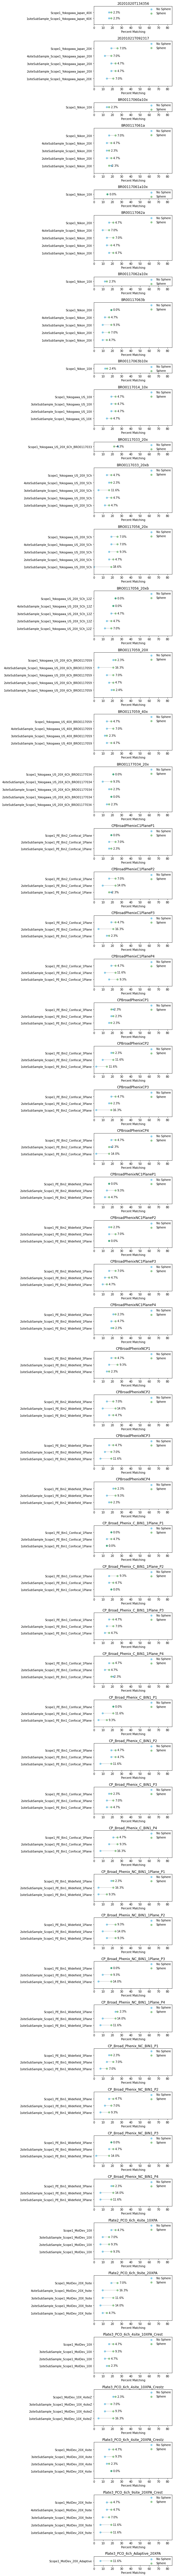

In [136]:
def dumbell_plot(df, group, rep_match, save_fig):
        n_plots = len(set(df.loc[:, group]))
        heights = [len(i) for _, i in df.groupby(group)] # Custom subplot dims based on input data
        plot_height = n_plots * 3
        fig, ax_ = plt.subplots(n_plots, 1, figsize=[5, plot_height], gridspec_kw={'height_ratios':heights})
        for ax, (_, df_group) in zip(ax_.flatten(), df.groupby(group)):
                df_len = df_group[df_group["sphering"]==True].shape[0]
                ax.set_xlim([0, 85])
                ax.set_ylim([-1, df_len]) # Helps with nice y-axis label alignment
                ax.hlines(df_group[df_group["sphering"]==True]["Batch"], 
                        xmin=df_group[df_group["sphering"]==False][rep_match].astype(float), 
                        xmax=df_group[df_group["sphering"]==True][rep_match].astype(float),
                        color='grey', alpha=0.4)
                ax.scatter(df_group[df_group["sphering"]==False][rep_match].astype(float),
                        df_group[df_group["sphering"]==False]["Batch"].astype(str),
                        color='skyblue', alpha=1,
                        label="No Sphere")
                ax.scatter(df_group[df_group["sphering"]==True][rep_match].astype(float),
                        df_group[df_group["sphering"]==True]["Batch"],
                        color='green', alpha=0.4,
                        label="Sphere")
                # Sort=False to maintain order used in ax.hlines
                for (_, row), y in zip(df_group.groupby("Batch", sort=False), range(0, df_len+1)):
                        difference_value = row.loc[row['sphering']==True][rep_match].iloc[0] - row.loc[row['sphering']==False][rep_match].iloc[0]
                        ax.annotate(f"{difference_value:.1f}%", (row.loc[row["sphering"]==True][rep_match].iloc[0]+2, y), va="center")
                ax.set_title(f"{list(set(df_group[group]))[0]}")
                ax.set_xlabel(" ".join(rep_match.split("_")))
                # ax.legend(ncol=1, bbox_to_anchor=(1, 1.001), loc="lower right", frameon=False)
                ax.legend(ncol=1, frameon=False, prop={'size': 10}, borderpad=0)
        fig.set_facecolor("white")
        fig.subplots_adjust(hspace=n_plots/100)

        if save_fig:
                fig.savefig(f"figures/{rep_match}_dumbell_plot.png", bbox_inches = 'tight', dpi=300)

# dumbell_plot(df_matching, "Assay_Plate_Barcode", "Percent_Matching", save_fig=False)
dumbell_plot(df_matching, "Assay_Plate_Barcode", "Percent_Matching", save_fig=True)
dumbell_plot(df_replicating, "Assay_Plate_Barcode", "Percent_Replicating", save_fig=True)

In [323]:
# Hide code output plots
%%capture 

# Recreate distribution plots
def distribution_plots(df, save_fig=False, outfile=None):

    n_experiments = df.shape[0]

    fig, ax_ = plt.subplots(n_experiments, 1, figsize=[12, n_experiments*8])
    for i, ax in zip(df.index, ax_.flatten()):
        ax.hist(df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
        ax.hist(df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
        ax.axvline(df.loc[i,'Value_95'], label='95% threshold')
        ax.legend(fontsize=20)
        ax.set_title(
            f"{df.loc[i,'Vendor']}\n" +
            f"Batch = {df.loc[i, 'Batch']}\n" +
            f"Plate = {df.loc[i, 'Assay_Plate_Barcode']}\n" +
            f"Percent Replicating = {df.loc[i,'Percent_Replicating']}",
            fontsize=25
        )
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel("Density", fontsize=25)
        ax.set_xlabel("Replicate correlation", fontsize=25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.tight_layout()

    if save_fig:
        if outfile is not None:
            print(f"Saving figure to: {outfile}")
            fig.savefig(f"{outfile}", bbox_inches = 'tight')
        else:
            print("Saving figure to: distribution-plot.png")
            fig.savefig("distribution-plot.png", bbox_inches = "tight")
    return fig

distribution_plots(df_replicating.loc[df_replicating["sphering"]==True], save_fig=True, outfile="figures/distribution-with-sphering.png")
distribution_plots(df_replicating.loc[df_replicating["sphering"]==False], save_fig=True, outfile="figures/distribution-no-sphering.png")


# FoV and cell count analysis using the *siteSubSample* profiles

In [7]:
def add_total_cell_counts(df, profile_path):
    out_df = df.copy()
    for i in df.index:
        batch = df.loc[i, "FoV_Batch"]
        barcode = df.loc[i, "Assay_Plate_Barcode"]
        load_path = os.path.join(profile_path, batch, barcode, f"{barcode}_normalized_negcon.csv.gz")
        load_df = pd.read_csv(load_path)
        sum_cells = sum(load_df.loc[:,"Metadata_Count_Cells"])
        print(sum_cells)
        out_df.loc[i, "Cell_Count"] = sum_cells
    return out_df

df_replicating = add_total_cell_counts(fov_df_replicating, "../jump-scope/profiles/")

df_replicating
# fov_df_matching


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


511430
617546
608864
132155
137083
146416
249089
251168
247467
118366
121803
120897
122580
118403
121765
120942
122600
116849
119891
119069
120286
115917
119183
118130
119331
114570
117449
117256
118483
114632
117413
116004
117165
113407
116253
115489
116462
113150
115572
114270
115627
159030
34078
518568
119805
129356
129682
110990
92622
30300
978703
1185629
1163084
255222
248024
273991
519409
521314
528034
231584
239479
238725
259919
231775
239378
238857
260086
228594
235500
235314
254821
226942
234067
233583
252056
224031
231023
231224
250051
224155
230939
229014
231021
222156
228464
228139
246381
221350
227179
226297
243928
282763
1032116
236567
257672
257747
232244
217868
57421
1530258
1823208
1800903
398159
373264
402157
771694
767801
783955
399392
1516909
368468
403905
403600
352472
327204
86955
505512
554863
1000889
992836
1005237
563579
489988
544244
543826
489099
452567
116595


,Vendor,Batch,FoV_Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,...,Unnamed: 11,z_plane,BF_Zplanes,Anomaly,Replicating,Null_Replicating,Percent_Replicating,Value_95,sphering,Cell_Count
0,MolDev,Scope1_MolDev_10X,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,1,1,10,...,NaN,1,NaN,none,"[-0.0035480679468849917, -0.02713708204376649,...","[0.001694759748161698, 0.0528504329439769, -0....",17.777778,0.388786,False,511430.0
1,MolDev,Scope1_MolDev_10X,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,1,1,10,...,NaN,1,NaN,none,"[0.02610832466873135, 0.039859624120984205, 0....","[0.052214507933799226, 0.011735457766832307, 0...",23.333333,0.487085,False,617546.0
2,MolDev,Scope1_MolDev_10X_4siteZ,1siteSubSample_Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,1,1,10,...,NaN,1,NaN,none,"[-0.013443456762634672, -0.015926390000716273,...","[0.09052982307041973, 0.20887750567030378, 0.1...",20.000000,0.669894,False,608864.0
3,MolDev,Scope1_MolDev_20X_4site,1siteSubSample_Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,1,1,20,...,NaN,1,NaN,none,"[-0.06992517003129306, -0.05415402501605597, 0...","[0.36176654867577374, -0.05915438918093827, -0...",35.555556,0.306914,False,132155.0
4,MolDev,Scope1_MolDev_20X_9site,1siteSubSample_Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,1,1,20,...,NaN,1,NaN,none,"[0.09293820147883512, -0.027940625654125105, -...","[0.0029564902214608054, -0.0057205082804652795...",25.555556,0.402056,False,137083.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4,1,20,...,NaN,12,13,none,"[0.11787495125566441, 0.16802342032189477, 0.2...","[0.12815049007231577, 0.3830252303249954, -0.0...",38.888889,0.366667,False,544244.0
124,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch_12Z,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4,1,20,...,NaN,12,15,none,"[0.16959184770712224, 0.22233273446776852, 0.0...","[0.04571653924243388, 0.08741382190103203, 0.0...",45.555556,0.322584,False,543826.0
125,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4,1,20,...,NaN,12,15,none,"[0.38973771531652707, 0.01460006207482378, 0.1...","[0.43904923658743233, 0.43547842233961065, -0....",20.000000,0.616396,False,489099.0
126,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4,1,20,...,NaN,12,15,none,"[-0.04580911089947984, -0.041760079848138204, ...","[0.1692845448623285, 0.006210661153718592, 0.8...",21.111111,0.674445,False,452567.0


In [ ]:
def fov_cell_count_plots(df, save_fig=False, outfile=None):
    n_experiments = len(df)
    fig, ax_ = plt.subplots(n_experiments, 1, figsize=[12, n_experiments*8], facecolor="white")

    for ((_, rows), ax) in zip(df, ax_.flatten()):
        x = rows.loc[:,"Cell_Count"]
        y = rows.loc[:,"Percent_Replicating"]
        ax.scatter(x, y)
        ax.plot(x, y)
        for i, txt in enumerate(range(0, len(x))):
            ax.annotate(rows.loc[:,"Sites-SubSampled"].values[i], 
            (x.values[i], y.values[i]),
            fontsize=25,
            horizontalalignment='center',
            verticalalignment='bottom'
            )

        ax.set_title(
            f"{rows.loc[:,'Vendor'].unique()}\n" +
            f"Batch = {rows.loc[:, 'FoV_Batch'].unique()}\n" +
            f"Plate = {rows.loc[:, 'Assay_Plate_Barcode'].unique()}\n",
            fontsize=25
        )
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel("Percent Replicating", fontsize=25)
        ax.set_xlabel("Number of Cells", fontsize=25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.tight_layout()

    if save_fig:
        if outfile is not None:
            print(f"Saving figure to: {outfile}")
            fig.savefig(f"{outfile}", bbox_inches = 'tight')
        else:
            print("Saving figure to: fov_count_plot.png")
            fig.savefig("fov_count_plot.png", bbox_inches = "tight")
    return fig

fov_cell_count_plots(fov_df_replicating.groupby(["Batch", "Assay_Plate_Barcode"]), save_fig=True, outfile="figures/fov_cell_count.png")


# Dropout plots

In [ ]:
### Creating dropout datasets + matrix

def return_prop95(dataframe, match_or_rep="replicating", enable_sphering=False):
    """
    dataframe: pandas.DataFrame to find the prop95 for 
    """
    n_samples = 1000
    n_replicates = 4  #number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    # metadata_perturbation = 'Metadata_broad_sample'
    # group_by_feature = 'Metadata_broad_sample'
    metadata_perturbation = 'Metadata_pert_iname'
    group_by_feature = 'Metadata_pert_iname'
    if match_or_rep.casefold() == "replicating":
        if enable_sphering:
            _, _, prop_95_replicating_sphere, _ = utilssphering.calculate_percent_replicating_MOA("", "", data_df=dataframe)
            return prop_95_replicating_sphere

        if not enable_sphering: 
            plate_df = utils.remove_negcon_empty_wells(dataframe)
            replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
            prop_95_replicating, _ = utils.percent_score(null_replicating, replicate_corr, how='right')
            return prop_95_replicating

    if match_or_rep.casefold() == "matching":
        if enable_sphering:
            _, _, prop_95_matching_sphere, _ = utilssphering.calculate_percent_matching_MOA("", "", data_df=dataframe)
            return prop_95_matching_sphere

        if not enable_sphering:
            plate_df = utils.remove_negcon_empty_wells(dataframe)
            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
            prop_95_matching, _ = utils.percent_score(null_matching, matching_corr, how='right')
            return prop_95_matching


def do_feature_select(plate_df):
    """
    Find the column names that are CellProfiler features. Eg. column names
    that start with "Nuclei" or "Cytoplasm"
    """
    feature_select_features = pycytominer.cyto_utils.infer_cp_features(
        plate_df
    )
    # For all of the cellprofiler features, perform these operations on them
    return pycytominer.feature_select(
        profiles=plate_df,
        features=feature_select_features,
        operation=['variance_threshold','correlation_threshold',
        'drop_na_columns','blocklist']
    )

def all_combo_dropouts_in_a_category(category_list,outfile,subsample=None):
    """
    Create a database with dropped out features

    category_list: the categories to drop out (for example, Nuclei, Cytoplasm, Cells)
    outfile: save csv path
    """
    # For all of the categories, find all possible combinations with itertools.combinations
    to_try = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]

    # If the output csv already exists, check what dropouts have already been tried
    # Don't try them again
    if os.path.exists(outfile):
        dropout_df = pd.read_csv(outfile)
        tried=list(dropout_df['Dropout'])
        print(f"Already try {tried},skipping")
        to_try = [x for x in to_try if str(x) not in tried]
    # Otherwise, dropout columns will be generated from scratch
    else:
        dropout_df = pd.DataFrame()
    
    # For the given categories, go through each combination (eg. ('Cells', 'Cytoplasm'), ('Nuclei', 'Cytoplasm') etc.)
    for eachdropout in to_try:
        # Get what columns are expected. I don't like this method
        normalized_master = pd.read_csv('../profiles-pilots/profiles/Stain5_CondC_Standard/BR00120274/BR00120274_normalized_negcon.csv.gz')
        col_list = normalized_master.columns
        if subsample:
             for each_item in subsample:
                metadata_list = [x for x in col_list if 'Metadata' in x] 
                col_list = metadata_list+[x for x in col_list if each_item in x]
        for each_item in eachdropout:
            # Create a list of columns that DOESN'T contain the categories being iterated
            # Thus this will iterate over all categories (eg. nuclei, cell, cytoplasm) and
            # drop all of the column names
            col_list = [x for x in col_list if each_item not in x]
        dropout_dict = {}
        temp_dropout_dict = {}
        # Code unique to this dataset. Iterate through plates
        for eachplate in range(70,78):
            try:
                # Read only the columns previously defined for each plate being iterated over
                # Again, don't like this hardcoding. Should be some sort of os.walk situation
                normalized = pandas.read_csv(
                    f'../profiles-pilots/profiles/Stain5_CondC_Standard/BR001202{eachplate}/BR001202{eachplate}_normalized_negcon.csv.gz',
                    usecols=col_list)
                # For the loaded dataset, calculate feature selection AFTER column dropout
                feature_select = do_feature_select(normalized)
                temp_dropout_dict[f'{eachplate}_featnum']=len(feature_select.columns)
                # Now, calculate the perc_rep for the dropout dataset 
                ### NOTE: in utilsphering, calculate_percent_replicating_MOA has been updated to return
                ### replicate_corr, null_corr, prop_95, value_95_replicating
                ### In this example, calculate_percent_replicating_MOA is **only returning prop_95**
                dropout_dict[f'BR001202{eachplate}']= calculate_percent_replicating_MOA('','',data_df=feature_select)
            except:
                dropout_dict[f'BR001202{eachplate}']=0
        # Convert the calculated perc_rep into np.array for each dropout 
        results_array = np.array(list(dropout_dict.values()))
        for k,v in temp_dropout_dict.items():
            dropout_dict[k]=v
        # For the dropout dataset created, calculate the mean perc_replicating for ALL of the plates
        # Why all of the plates? Are these replicates?
        # Means are calculated within each dropout group
        dropout_dict['Mean']=results_array.mean()
        dropout_dict['Median']=np.median(results_array)
        dropout_dict['Standard deviation']=np.std(results_array)
        dropout_dict['Dropout']=eachdropout
        dropout_dict['Remaining'] = [x for x in category_list if x not in eachdropout]
        dropout_dict['n_columns']=len(col_list)
        dropout_df = dropout_df.append(dropout_dict,ignore_index=True)
        print(eachdropout,dropout_dict['Mean'])
        dropout_df.to_csv(outfile,index=False)
    print(dropout_df['Mean'].describe())
    print(dropout_df['Median'].describe())

def category_dropout(
    dataframe, 
    plate_barcode, 
    category_list, 
    match_or_rep_or_both="replicating",
    enable_sphering="both", 
    outfile=None
):
    input_columns = dataframe.columns
    possible_combinations = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]
    rep_df_list = list()
    match_df_list = list()

    # Check if dropout has previously been performed
    # if os.path.exists(outfile):
    #     # Limitation of this implementation:
    #     # If you switch from sphering to not sphering, this will fail to 
    #     # run the analysis without sphering as it only checks the 'dropout'
    #     # column combinations and not any other column (such as if sphering was T/F).
    #     dropout_df = pd.read_csv(outfile)
    #     rep_df_list.append(dropout_df)
    #     match_df_list.append(dropout_df)
    #     tried=list(dropout_df["dropout"])
    #     print(f"Already tried {tried}. Skipping.")
    #     possible_combinations = [x for x in possible_combinations if str(x) not in tried]
    #     # Otherwise, dropout columns will be generated from scratch

    if len(possible_combinations) == 0:
        # Either no combinations available or they're already present in the outfile
        print("All combinations already computed")
        return

    # Iterate through the combination to dropout
    for dropout_group in possible_combinations: 
        col_list = input_columns
        # Within the droupout group, find the column to actually drop
        for each_item in dropout_group:
            # Only keep columns that don't contain the dropout
            col_list = [x for x in col_list if each_item not in x]
        print(f"---- Dropping: {dropout_group} ----")
        try:
            dropped_dataframe = pd.DataFrame(dataframe[col_list])
            feature_select = do_feature_select(dropped_dataframe)
        except:
            feature_select = dropped_dataframe
        # return feature_select
        if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
            if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                try:
                    # Added to tackle an issue where longer dropout runs would error out due to NaN input
                    # Unsure of the source of the NaN input. This is a temporary solution.
                    prop_95 = return_prop95(feature_select, match_or_rep="replicating", enable_sphering=True)
                except:
                    prop_95 = 0
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": True,
                    "percent_replicating": [prop_95]
                })
                rep_df_list.append(_df)
            if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both":
                try:
                    prop_95 = return_prop95(feature_select, match_or_rep="replicating", enable_sphering=False)
                except:
                    prop_95 = 0                
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": False,
                    "percent_replicating": [prop_95]
                })
                rep_df_list.append(_df)
        if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
            if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                try:
                    prop_95 = return_prop95(feature_select, match_or_rep="matching", enable_sphering=True)
                except:
                    prop_95 = 0
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": True,
                    "percent_matching": [prop_95]
                })
                match_df_list.append(_df)
            if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both":
                try:
                    prop_95 = return_prop95(feature_select, match_or_rep="matching", enable_sphering=False)
                except:
                    prop_95 = 0
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": False,
                    "percent_matching": [prop_95],
                })
                match_df_list.append(_df)
        
    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        rep_df = pd.concat(rep_df_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        match_df = pd.concat(match_df_list, ignore_index=True)
                
    # Merge so perc rep and match is in the same place
    if match_or_rep_or_both.casefold() == "both":
        merged_df = rep_df.merge(match_df, how="inner")
        if outfile is not None:
            merged_df.to_csv(outfile,index=False)
        return merged_df
    if match_or_rep_or_both.casefold() == "replicating":
        if outfile is not None:
            rep_df.to_csv(outfile,index=False)
        return rep_df
    if match_or_rep_or_both.casefold() == "matching":
        if outfile is not None:
            match_df.to_csv(outfile,index=False)
        return match_df
        
# TODO: Check that this is accurately dropping, integrate with os.walk, integrate with heatmap matrix
# No need to integrate with os.walk. Use metadata csv



load_file = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA_normalized_negcon.csv.gz"
test_data = pd.read_csv(load_file)
drops = category_dropout(test_data, "Plate2_PCO_6ch_4site_10XPA", ['Nuclei', 'Cells', 'Cytoplasm'], "both", "both", "test.csv")
drops
# ['Nuclei','Cells','Cytoplasm']


In [ ]:
# Gather the dropout data
df_list = list()
t = pd.DataFrame()
_, parent_folders, _ = next(os.walk("../jump-scope/profiles/"))
for batch_name in parent_folders:
    _, subdirs, _ = next(os.walk(f"../jump-scope/profiles/{batch_name}"))
    for plate_barcode in subdirs:
        batch_path = f"../jump-scope/profiles/{batch_name}/{plate_barcode}"
        for _, _, files in os.walk(batch_path):
            for filename in files:
                if filename.endswith("-dropout.csv"):
                    dropout_path = f"{batch_path}/{plate_barcode}-dropout.csv"
                    dropout_df = pd.read_csv(dropout_path)
                    dropout_df["batch_name"] = batch_name
                    df_list.append(dropout_df)

collated_dropout_df = pd.concat(df_list)
collated_dropout_df.to_csv("checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv")

# Dropout visualisations

In [42]:
import seaborn as sns
import textwrap

In [85]:
dropout_df = pd.read_csv("checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv", converters={'dropout':ast.literal_eval})
dropout_df

,Unnamed: 0,assay_plate_barcode,num_features,dropout,n_columns,sphering,percent_replicating,percent_matching
0,0,Plate3_PCO_6ch_4site_10XPA_Crest,522,(),4357,True,60.000000,20.930233
1,1,Plate3_PCO_6ch_4site_10XPA_Crest,522,(),4357,False,33.333333,13.953488
2,2,Plate3_PCO_6ch_4site_10XPA_Crest,413,"(Cytoplasm,)",2916,True,60.000000,16.279070
3,3,Plate3_PCO_6ch_4site_10XPA_Crest,413,"(Cytoplasm,)",2916,False,28.888889,16.279070
4,4,Plate3_PCO_6ch_4site_10XPA_Crest,362,"(Nuclei,)",2909,True,55.555556,20.930233
...,...,...,...,...,...,...,...,...
2939,11,CP_Broad_Phenix_NC_BIN1_P3,228,"(Nuclei, Cells)",1173,False,45.555556,20.930233
2940,12,CP_Broad_Phenix_NC_BIN1_P3,238,"(Nuclei, Cytoplasm)",1188,True,53.333333,16.279070
2941,13,CP_Broad_Phenix_NC_BIN1_P3,238,"(Nuclei, Cytoplasm)",1188,False,44.444444,16.279070
2942,14,CP_Broad_Phenix_NC_BIN1_P3,11,"(Nuclei, Cells, Cytoplasm)",11,True,0.000000,0.000000


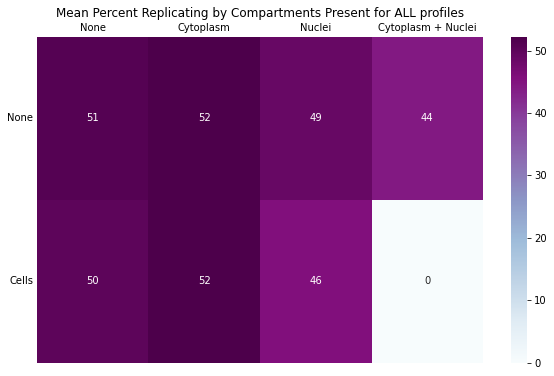

In [133]:
def create_and_graph_heatmap(df,col_list,row_list,cmap,title,figsize,xbreaklen=120,ybreaklen=180,xkcd=False):
    full_col_list = []
    full_col_list_for_labels = []
    full_row_list= []
    full_row_list_for_labels = []
    for eachlen in range(len(col_list)+1):
        full_col_list += sorted([str(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
        full_col_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
    for eachlen in range(len(row_list)+1):
        full_row_list += sorted([str(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
        full_row_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
    square=pd.DataFrame(columns=full_col_list,index=full_row_list)
    for _,row in df.iterrows():
        sub_rows=[]
        sub_cols=[]
        for thing in row['dropout']:
            if thing not in col_list:
                sub_cols.append(thing)
            else:
                sub_rows.append(thing)
        sub_rows.sort()
        sub_cols.sort()
        # square[str(sub_cols)][str(sub_rows)]=row['percent_replicating']*100
        square.loc[str(sub_cols),str(sub_rows)] = row["percent_replicating"]
    square=square.fillna(0)
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_facecolor("white")
    # if xkcd:
    #     cmap=sns.light_palette(cmap,input='xkcd',as_cmap=True)
    g=sns.heatmap(square,cmap=cmap,annot=True)
    xlabels=['None']
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    for label in full_col_list_for_labels[1:]:
        xlabels.append(textwrap.fill(label, width=xbreaklen/len(full_col_list_for_labels),break_long_words=False))
    g.set_xticklabels(xlabels, rotation=0)
    ylabels=['None']
    for label in full_row_list_for_labels[1:]:
        ylabels.append(textwrap.fill(label, width=ybreaklen/len(full_row_list_for_labels),break_long_words=False))
    g.set_yticklabels(ylabels, rotation=0)
    g.set_title(title)
    # plt.savefig(f'figures/{title}.png',dpi=300)
    
    
create_and_graph_heatmap(
    dropout_df,
    col_list=['Nuclei','Cytoplasm'],
    row_list=['Cells'],
    cmap='BuPu',
    title = 'Mean Percent Replicating by Compartments Present for ALL profiles',
    figsize=(10,6))


In [108]:
# Dropout groups
# Basically, make matrix plots for profile groups
# ie. compare dropouts for the same batch that have different site subsamples

subsample_df = pd.read_csv('output/FoV-experiment-metadata.tsv', sep='\t')

dropout_df = pd.read_csv(
    "checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv", 
    converters={'dropout':ast.literal_eval}
)
dropout_df


,Unnamed: 0,assay_plate_barcode,num_features,dropout,n_columns,sphering,percent_replicating,percent_matching,batch_name
0,0,Plate3_PCO_6ch_4site_10XPA_Crest,522,(),4357,True,60.000000,20.930233,2siteSubSample_Scope1_MolDev_10X
1,1,Plate3_PCO_6ch_4site_10XPA_Crest,522,(),4357,False,33.333333,13.953488,2siteSubSample_Scope1_MolDev_10X
2,2,Plate3_PCO_6ch_4site_10XPA_Crest,413,"(Cytoplasm,)",2916,True,60.000000,16.279070,2siteSubSample_Scope1_MolDev_10X
3,3,Plate3_PCO_6ch_4site_10XPA_Crest,413,"(Cytoplasm,)",2916,False,28.888889,16.279070,2siteSubSample_Scope1_MolDev_10X
4,4,Plate3_PCO_6ch_4site_10XPA_Crest,362,"(Nuclei,)",2909,True,55.555556,20.930233,2siteSubSample_Scope1_MolDev_10X
...,...,...,...,...,...,...,...,...,...
2939,2939,CP_Broad_Phenix_NC_BIN1_P3,228,"(Nuclei, Cells)",1173,False,45.555556,20.930233,Scope1_PE_Bin1_Widefield_3Plane
2940,2940,CP_Broad_Phenix_NC_BIN1_P3,238,"(Nuclei, Cytoplasm)",1188,True,53.333333,16.279070,Scope1_PE_Bin1_Widefield_3Plane
2941,2941,CP_Broad_Phenix_NC_BIN1_P3,238,"(Nuclei, Cytoplasm)",1188,False,44.444444,16.279070,Scope1_PE_Bin1_Widefield_3Plane
2942,2942,CP_Broad_Phenix_NC_BIN1_P3,11,"(Nuclei, Cells, Cytoplasm)",11,True,0.000000,0.000000,Scope1_PE_Bin1_Widefield_3Plane


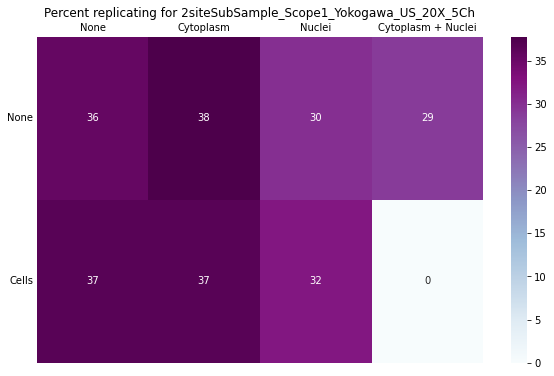

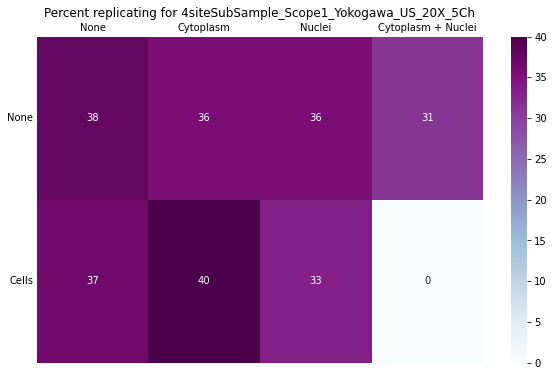

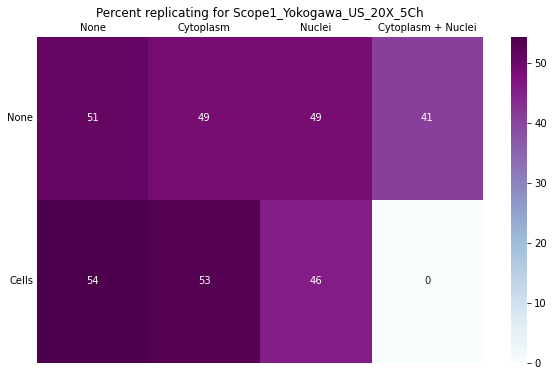

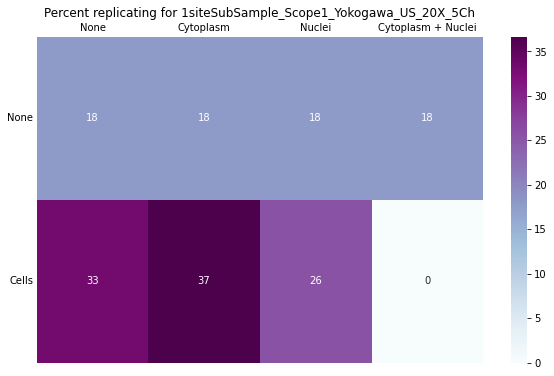

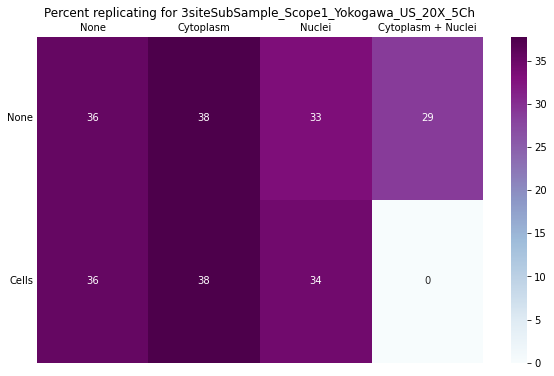

In [147]:
# Create a new DF that combines the dropout results with the subsample info

batch_list = list(set(dropout_df.loc[:,"batch_name"]))
plate_list = list(set(dropout_df.loc[:, "assay_plate_barcode"]))
for plate in plate_list:
    if plate == "BRO0117033_20xb":
    # print(plate)
        t = dropout_df.loc[dropout_df["assay_plate_barcode"] == plate]
        for subset in set(t["batch_name"]):
            subset_df = t[t["batch_name"] == subset]
            create_and_graph_heatmap(
                subset_df,
                col_list=['Nuclei','Cytoplasm'],
                row_list=['Cells'],
                cmap='BuPu',
                title = f"Percent replicating for {subset}",
                figsize=(10,6))



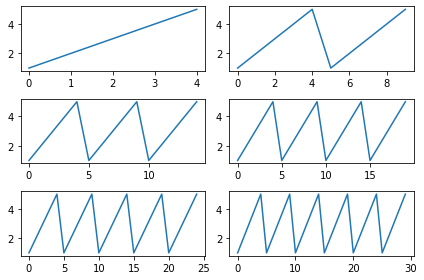

In [153]:
# Passing ax objects to a function

fig, ax = plt.subplots(3,2)
def test_subplotting(ax, num):
    ax.plot([1,2,3,4,5]*num)
    fig.set_facecolor("white")
    plt.tight_layout()

for i, ax_ in enumerate(ax.flatten()):
    test_subplotting(ax_, i+1)

In [ ]:
# Alt 

def create_and_graph_heatmap(df,col_list,row_list,ax_=None,xbreaklen=120,ybreaklen=180):
    full_col_list = []
    full_col_list_for_labels = []
    full_row_list= []
    full_row_list_for_labels = []
    for eachlen in range(len(col_list)+1):
        # This works out all of the combinations for the given col list (eg. nuclei, nuclei+cells...)
        # Each combination is sorted so the label order is consistent, then the whole list itself is sorted
        # itertools.combinations will only return combinations that are equal in length to each len,
        # thus only combination lengths of 1 and 2 will be returned for col_list=["Nuclei", "Cells"]
        full_col_list += sorted([str(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
        # This generates the actual labels for above, ready to be displayed
        full_col_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
    for eachlen in range(len(row_list)+1):
        full_row_list += sorted([str(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
        full_row_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
    square=pd.DataFrame(columns=full_col_list,index=full_row_list)
    for _,row in df.iterrows():
        sub_rows=[]
        sub_cols=[]
        for thing in row['dropout']:
            if thing not in col_list:
                sub_cols.append(thing)
            else:
                sub_rows.append(thing)
        sub_rows.sort()
        sub_cols.sort()
        square.loc[str(sub_cols),str(sub_rows)] = row["percent_replicating"]
    square=square.fillna(0)
    if ax_ is None:
        fig, ax = plt.subplots(figsize=(15,15))
    fig.set_facecolor("white")
    g=sns.heatmap(square,annot=True)
    xlabels=['None']
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    for label in full_col_list_for_labels[1:]:
        xlabels.append(textwrap.fill(label, width=xbreaklen/len(full_col_list_for_labels),break_long_words=False))
    g.set_xticklabels(xlabels, rotation=0)
    ylabels=['None']
    for label in full_row_list_for_labels[1:]:
        ylabels.append(textwrap.fill(label, width=ybreaklen/len(full_row_list_for_labels),break_long_words=False))
    g.set_yticklabels(ylabels, rotation=0)
    g.set_title(title)
    # plt.savefig(f'figures/{title}.png',dpi=300)
    
    
create_and_graph_heatmap(
    dropout_df,
    col_list=['Nuclei','Cytoplasm'],
    row_list=['Cells'],
    cmap='BuPu',
    title = 'Mean Percent Replicating by Compartments Present for ALL profiles',
    figsize=(10,6))


In [158]:
category_list = ['Nuclei','Cytoplasm', "Cell"]
sorted([(" + ").join(y) for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))])

['',
 'Cell',
 'Cytoplasm',
 'Cytoplasm + Cell',
 'Nuclei',
 'Nuclei + Cell',
 'Nuclei + Cytoplasm',
 'Nuclei + Cytoplasm + Cell']

In [ ]:

def create_and_graph_heatmap(df,col_list,row_list,ax_=None,xbreaklen=120,ybreaklen=180):
    full_col_list = []
    full_col_list_for_labels = []
    full_row_list= []
    full_row_list_for_labels = []
    for eachlen in range(len(col_list)+1):
        full_col_list = sorted([y for x in range(len(col_list)+1) for y in list(set(itertools.combinations(col_list,x)))])
        full_col_list += sorted([str(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
        # This generates the actual labels for above, ready to be displayed
        sorted([y for x in range(len(col_list)+1) for y in list(set(itertools.combinations(col_list,x)))])
        full_col_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
    for eachlen in range(len(row_list)+1):
        full_row_list += sorted([str(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
        full_row_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
    square=pd.DataFrame(columns=full_col_list,index=full_row_list)
    for _,row in df.iterrows():
        sub_rows=[]
        sub_cols=[]
        for thing in row['dropout']:
            if thing not in col_list:
                sub_cols.append(thing)
            else:
                sub_rows.append(thing)
        sub_rows.sort()
        sub_cols.sort()
        square.loc[str(sub_cols),str(sub_rows)] = row["percent_replicating"]
    square=square.fillna(0)
    if ax_ is None:
        fig, ax = plt.subplots(figsize=(15,15))
    fig.set_facecolor("white")
    g=sns.heatmap(square,annot=True)
    xlabels=['None']
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    for label in full_col_list_for_labels[1:]:
        xlabels.append(textwrap.fill(label, width=xbreaklen/len(full_col_list_for_labels),break_long_words=False))
    g.set_xticklabels(xlabels, rotation=0)
    ylabels=['None']
    for label in full_row_list_for_labels[1:]:
        ylabels.append(textwrap.fill(label, width=ybreaklen/len(full_row_list_for_labels),break_long_words=False))
    g.set_yticklabels(ylabels, rotation=0)
    g.set_title(title)
    # plt.savefig(f'figures/{title}.png',dpi=300)

In [3]:
def create_moa_dataframe(experiment_metadata, profile_parent_dir, batch_col="Batch", match_or_rep_or_both="replicating", enable_sphering="both"):
    """
    batch_col is the name of the column to distinguish the profile parent folder. Eg. "Scope1_MolDev_10X" or "1siteSubSample_Scope1_MolDev_10X"
    Output df will also use this batch_col name
    """
    n_samples = 10000
    n_replicates = 4  #number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    metadata_perturbation = 'Metadata_broad_sample'
    group_by_feature = 'Metadata_broad_sample'

    corr_replicating_list = list()
    corr_matching_list = list()

    for ind, a_vendor in enumerate(experiment_metadata["Vendor"].unique()):
        print(ind)
        vendor_data = experiment_metadata.loc[experiment_metadata["Vendor"] == a_vendor]
        for a_batch in vendor_data[batch_col].unique():
            batch_data = vendor_data.loc[vendor_data[batch_col] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_feature_select_negcon_batch.csv.gz")
                load_data = pd.read_csv(data_path)
                # print(data_path)
                try:
                    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
                        if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                            sphere_bool = True
                            replicate_corr_sphere, null_replicating_sphere, prop_95_replicating_sphere, value_95_replicating_sphere = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)
                            corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        batch_col: a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        'Replicating':[replicate_corr_sphere],
                                                                        'Null_Replicating':[null_replicating_sphere],
                                                                        'Percent_Replicating':prop_95_replicating_sphere,
                                                                        'Value_95':value_95_replicating_sphere,
                                                                        'sphering': sphere_bool}, index=[ind]))

                        if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                            sphere_bool = False
                            plate_df = utils.remove_negcon_empty_wells(load_data)
                            replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
                            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
                            prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicate_corr, how='right')
                            corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        batch_col: a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        'Replicating':[replicate_corr],
                                                                        'Null_Replicating':[null_replicating],
                                                                        'Percent_Replicating':prop_95_replicating,
                                                                        'Value_95':value_95_replicating,
                                                                        'sphering': sphere_bool}, index=[ind]))

                    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
                        if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                            sphere_bool = True
                            matching_corr_sphere, null_matching_sphere, prop_95_matching_sphere, value_95_matching_sphere = utilssphering.calculate_percent_matching_MOA("", "", data_df=load_data)
                            corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Matching':[matching_corr_sphere],
                                                                    'Null_Matching':[null_matching_sphere],
                                                                    'Percent_Matching':prop_95_matching_sphere,
                                                                    'Value_95':value_95_matching_sphere,
                                                                    'sphering': sphere_bool}, index=[ind]))
                        
                        if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                            sphere_bool = False
                            plate_df = utils.remove_negcon_empty_wells(load_data)
                            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
                            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
                            prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')
                            corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Matching':[matching_corr],
                                                                    'Null_Matching':[null_matching],
                                                                    'Percent_Matching':prop_95_matching,
                                                                    'Value_95':value_95_matching,
                                                                    'sphering': sphere_bool}, index=[ind]))
                except:
                    print(f"Passed: {data_path}")
                    pass
    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = pd.concat(corr_replicating_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        corr_matching_df = pd.concat(corr_matching_list, ignore_index=True)
                
    # Merge metadata with output dataframes
    merge_columns = ['Vendor', batch_col, 'Assay_Plate_Barcode']
    if match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
        corr_matching_df = experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)
        return corr_replicating_df, corr_matching_df
    if match_or_rep_or_both.casefold() == "replicating":
        return experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
    elif match_or_rep_or_both.casefold() == "matching":
        return experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)

# df_replicating, df_matching = create_moa_dataframe(experiment_df, "../jump-scope/profiles/", match_or_rep_or_both="replicating", enable_sphering="yes")
df_replicating = create_moa_dataframe(experiment_df, "../jump-scope/profiles/", match_or_rep_or_both="replicating", enable_sphering="yes")

# df = create_moa_dataframe(pd.read_csv('output/experiment-metadata.tsv', sep='\t'), "../jump-scope/profiles/", match_or_rep_or_both="replicating", enable_sphering="no")

# df


0
1
2
3


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


4


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Passed: ../jump-scope/profiles/1siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059/BRO0117059_40x/BRO0117059_40x_normalized_feature_select_negcon_batch.csv.gz


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [53]:
# Why does scope/profiles/1siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059/BRO0117059_40x/BRO0117059_40x_normalized_feature_select_negcon_batch.csv.gz
# return ValueError: Input contains NaN. all of a sudden?

# Isolate this particular plate for debugging
problem_df = "../jump-scope/profiles/1siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059/BRO0117059_40x/BRO0117059_40x_normalized_feature_select_negcon_batch.csv.gz"
load_data = pd.read_csv(problem_df)
# load_data.fillna(0, inplace=True)
# (
#     replicate_corr_sphere, 
#     null_replicating_sphere, 
#     prop_95_replicating_sphere, 
#     value_95_replicating_sphere
# ) = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)




In [13]:
alt = "../jump-scope/profiles/Scope1_Yokogawa_US_40X_BRO0117059/BRO0117059_40x/BRO0117059_40x_normalized_feature_select_negcon_batch.csv.gz"
alt_load_data = pd.read_csv(alt)

In [21]:
[i for i in load_data.columns[load_data.isna().any()].tolist() if "Metadata" not in i]

['Cells_Neighbors_AngleBetweenNeighbors_10',
 'Cells_Neighbors_SecondClosestDistance_10',
 'Nuclei_Neighbors_AngleBetweenNeighbors_2',
 'Nuclei_Neighbors_FirstClosestDistance_2',
 'Nuclei_Neighbors_SecondClosestDistance_2']

In [19]:
[i for i in alt_load_data.columns[alt_load_data.isna().any()].tolist()]

['Metadata_broad_sample',
 'Metadata_InChIKey',
 'Metadata_pubchem_cid',
 'Metadata_moa',
 'Metadata_control_type',
 'Metadata_smiles']

In [80]:
load_data.drop(['Cells_Neighbors_AngleBetweenNeighbors_10',
 'Cells_Neighbors_SecondClosestDistance_10',
 'Nuclei_Neighbors_AngleBetweenNeighbors_2',
 'Nuclei_Neighbors_FirstClosestDistance_2',
 'Nuclei_Neighbors_SecondClosestDistance_2'], axis=1)

,Metadata_broad_sample,Metadata_solvent,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Count_Cells,Metadata_Count_Cytoplasm,Metadata_Count_Nuclei,Metadata_Object_Count,Metadata_InChIKey,...,Nuclei_Texture_InfoMeas2_DNA_5_01_256,Nuclei_Texture_InfoMeas2_ER_5_02_256,Nuclei_Texture_InfoMeas2_Mito_10_02_256,Nuclei_Texture_InfoMeas2_RNA_10_02_256,Nuclei_Texture_InverseDifferenceMoment_AGP_5_00_256,Nuclei_Texture_InverseDifferenceMoment_ER_5_00_256,Nuclei_Texture_InverseDifferenceMoment_Mito_20_03_256,Nuclei_Texture_SumEntropy_BrightField_20_03_256,Nuclei_Texture_SumVariance_ER_10_02_256,Nuclei_Texture_SumVariance_Mito_20_01_256
0,BRD-K80935598-001-01-1,DMSO,BRO0117059_40x,A01,1,149,149,149,149,ZYVXTMKTGDARKR-UHFFFAOYSA-N,...,-2.17930,-2.743600,-2.51420,-2.097000,0.96587,1.0599,0.817760,0.20019,-1.44200,-0.932430
1,BRD-K85776940-001-01-9,DMSO,BRO0117059_40x,A02,1,149,149,149,149,ODADKLYLWWCHNB-LDYBVBFYSA-N,...,-1.69160,-1.448300,-1.54820,-0.993660,0.75266,1.0129,0.300210,-0.17292,-1.08840,-0.570190
2,BRD-K25611237-001-02-1,DMSO,BRO0117059_40x,A03,1,84,84,84,84,QDBVSOZTVKXUES-UHFFFAOYSA-N,...,-2.18380,-1.138000,-0.43232,-1.664000,0.63584,1.5030,-0.085671,0.25474,-1.16630,0.053755
3,BRD-K66430217-001-03-8,DMSO,BRO0117059_40x,A04,1,122,122,122,122,CXJCGSPAPOTTSF-VURMDHGXSA-N,...,-2.05400,-1.901400,-0.35835,0.286850,0.65147,1.6629,-0.270450,1.64050,-1.29890,0.078028
4,BRD-K38627885-001-01-9,DMSO,BRO0117059_40x,A05,1,97,97,97,97,RFZQYGBLRIKROZ-PCLIKHOPSA-N,...,-0.19804,-0.016964,0.21218,-0.651130,0.41335,1.4520,-1.208900,4.04080,-0.81268,0.574130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,BRD-K16803204-001-01-6,DMSO,BRO0117059_40x,P20,1,90,90,90,90,RIJLVEAXPNLDTC-UHFFFAOYSA-N,...,-2.55740,-0.519520,0.19877,0.791290,1.15910,2.6576,0.006159,1.47370,-1.17560,0.475290
372,BRD-K02965346-001-07-5,DMSO,BRO0117059_40x,P21,1,71,71,71,71,FPYJSJDOHRDAMT-KQWNVCNZSA-N,...,-4.29620,-1.188900,-1.08460,-1.010800,2.31350,8.3890,1.222700,1.87290,-2.24580,-1.003200
373,BRD-K85776940-001-01-9,DMSO,BRO0117059_40x,P22,1,83,83,83,83,ODADKLYLWWCHNB-LDYBVBFYSA-N,...,-2.16940,-0.211340,-0.43453,0.084072,1.59050,4.2195,0.823840,1.39580,-1.46940,-0.369700
374,BRD-K19477839-001-07-6,DMSO,BRO0117059_40x,P23,1,81,81,81,81,BCZUAADEACICHN-UHFFFAOYSA-N,...,-2.05130,0.929130,1.48040,1.215000,1.45310,5.6830,-0.009359,2.28550,-1.59580,-0.204460


In [61]:
# load_data.loc[:, "Cells_Neighbors_AngleBetweenNeighbors_10"].values.tolist()

# load_data.loc[load_data[["Cells_Neighbors_AngleBetweenNeighbors_10", "Nuclei_Neighbors_AngleBetweenNeighbors_2"]].isnull(), load_data[nan_feat].isnull().any()]

load_data.loc[load_data["Cells_Neighbors_AngleBetweenNeighbors_10"].isnull(), load_data.isnull().any()][[i for i in load_data.columns[load_data.isna().any()].tolist() if "Metadata" not in i]]


,Cells_Neighbors_AngleBetweenNeighbors_10,Cells_Neighbors_SecondClosestDistance_10,Nuclei_Neighbors_AngleBetweenNeighbors_2,Nuclei_Neighbors_FirstClosestDistance_2,Nuclei_Neighbors_SecondClosestDistance_2
166,NaN,NaN,NaN,NaN,NaN
273,NaN,NaN,NaN,-3.2012,NaN


In [50]:
df = load_data.loc[load_data["Cells_Neighbors_AngleBetweenNeighbors_10"].isnull(), load_data.isnull().any()]

df.dropna(how='all')
df

,Metadata_broad_sample,Metadata_InChIKey,Metadata_pubchem_cid,Metadata_moa,Metadata_control_type,Metadata_smiles,Cells_Neighbors_AngleBetweenNeighbors_10,Cells_Neighbors_SecondClosestDistance_10,Nuclei_Neighbors_AngleBetweenNeighbors_2,Nuclei_Neighbors_FirstClosestDistance_2,Nuclei_Neighbors_SecondClosestDistance_2
166,BRD-K44227013-001-08-0,PHXJVRSECIGDHY-UHFFFAOYSA-N,24827000.0,Bcr-Abl kinase inhibitor,NaN,CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc3cnc4cccn...,NaN,NaN,NaN,NaN,NaN
273,BRD-K03063480-001-06-6,NDEXUOWTGYUVGA-LJQANCHMSA-N,NaN,CHK inhibitor,NaN,Cn1cc(cn1)-c1[nH]c2cc(NC(=O)[C@H](N)C3CCCCC3)c...,NaN,NaN,NaN,-3.2012,NaN


In [78]:
nan_feat = [i for i in load_data.columns[load_data.isna().any()].tolist() if "Metadata" not in i]
df = load_data.loc[load_data["Cells_Neighbors_AngleBetweenNeighbors_10"].isnull(), load_data.isnull().any()]
df = df.loc[:, nan_feat]
df.iloc[:, 0]
df.eq(df.iloc[:, 0], axis=0).all()

Cells_Neighbors_AngleBetweenNeighbors_10    False
Cells_Neighbors_SecondClosestDistance_10    False
Nuclei_Neighbors_AngleBetweenNeighbors_2    False
Nuclei_Neighbors_FirstClosestDistance_2     False
Nuclei_Neighbors_SecondClosestDistance_2    False
dtype: bool